In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import os
import sys
import importlib

from scipy import signal

# some usefull function from the previous notebook were copied in kfold.py:
function_dir = os.path.join(os.getcwd(), 'functions')
sys.path.append(function_dir)

import kfold as kf
importlib.reload(kf) #to make sure the last version of kfold is used 

<module 'kfold' from 'C:\\Users\\valla\\Documents\\GitHub\\EAWAG\\Forecast\\Summary\\Baseline design\\functions\\kfold.py'>

# Baseline models
In order to compare our more advanced models to some realistic heuristics, several baseline models can be designed. They can be grouped in two different classes: Markov and non-Markov. Indeed, a Markovian model is considering that all the information needed to describe the system are present in the latest set of measurement. These models then rely on explicitly describing the system in more detail: An exaggerated example could be described as follow: If it rains, then the chlorophyll a concentration increase after 15 days. A non-Markovian model could simply find this relation, but at the cost of a bigger number of possible combinations. On the other hand, one could also see that it is not simply the rain that increase the concentration of chlorophyll a after a delay, but rather that the rain is increasing the amount of nutrient in the water body, and this increase increase then causes a bigger growth rate of the phytoplankton. If the system is defined to this scale, then it could better be described by a Markovian model: the information that it has rained 15 days ago can still be found in the amount of nutrient, or in the population of juvenile phytoplankton.

More formally, a Markovian model considers the following evolution of a dynamical system:

$X(t) = F(X(t-1))$

Where $X(t)$ represent all the different variables of the system at time t, and $F$ is the function that our model is trying to estimate. 

A non-Markov process would have the form:

$X(t) = F(\{X(t-i)|i>0\})$


Note that formally, not all of the variables in $X$ need to be measured, and a model can try to approximate them anyways: this latest case is known as partially observable Markov process, and will be discarded for now.

As one can see, a same model can be Markovian or non-Markovian simply depending on its input, thus all of the baselines will have the possibility to be one or the other.

In [3]:
#load the dataset
data_path = "..\\..\\..\\Datasets\\Forecasting_aqua\\data_h_rolling_cst_int_v4.csv"
format = "%Y-%m-%d %H:%M:%S"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], format=format)
try:
    df.drop("sample",axis=1,inplace=True)
except:
    pass
df['Datetime']= time_df
#According to the work of Stefanie Merkly, these keys were more important than the others to predict chorophill a
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
#add some usefull variables at the end of the table
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
#drop the first datapoints the first months are only meteorological data
first_point = (~df['diatom'].isnull()).idxmax()
dfs = df.drop(index=range(first_point))
df = dfs.set_index('Datetime')

#the test part of the dataset is not used in this part
#portion of the data used for the test
test_prop = 0.15

test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()

# Auto Regressive Model
A regressive model is described as follow:

$\hat{X}(t+l)=\sum_{i=0}^{i<k}D_i X(t-i)$

Where $X(t)$ is a column vector representing all the variables at time t, $\hat X(t+l)$ is vector representing the estimation of the future state of the system $l$ time steps in the future, and $D_i$ are diagonal matrices of parameters for each time step taken as input. Reusing the description above, the model AR(1) (for autoregressive with k=1) would be markovian, whereas for any k>1 the model would be non-Markovian

In [4]:
class AR:
    def __init__(self,target_keys:list,k,CP=False):
        
        #for the implementation, a different model is used for each variables:
        self.skmodels = [LinearRegression() for _ in target_keys]
        self.k = k
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.idxtarget = []
        self.CP = CP
    def fit(self,inputs,target,breakpoints):
        if not self.CP:
            inputs = inputs.drop(columns=['Datetime'],errors='ignore')
            self._scalerin = self._scalerin.fit(inputs.values)
            self._scalerout = self._scalerout.fit(target.values)
            ninp = self._scalerin.transform(inputs.values)
            #fill nans with 0s
            ninp = np.nan_to_num(ninp)
            ntar = self._scalerout.transform(target.values)
            isnan = np.isnan(ntar);
            ntar = np.nan_to_num(ntar)
            for idx,target in enumerate(self.target_keys):
                #stack the input variable so that k points are given for each target:
                idx_x = inputs.keys().get_loc(target)
                self.idxtarget.append(idx_x)
                x = np.zeros((len(inputs)-self.k+1,self.k))
                for i in range(self.k):
                    x[:,i] = ninp[i:len(inputs)-self.k+1+i,idx_x]
                y = ntar[self.k-1:,idx]
                #put a weight of 0 on target that were inputed as nans
                w = ~isnan[self.k-1:,idx]
                self.skmodels[idx].fit(x,y,sample_weight=w)
    def pred(self,inputs,breakpoints):
        if self.CP:
            if len(inputs)==0:
                return np.zeros((0,len(self.idxtarget)))
            else:
                return(inputs[self.target_keys].values)
        else:
            inputs = inputs.drop(columns=['Datetime'],errors='ignore')
            if len(inputs)==0:
                return np.zeros((len(inputs),len(self.target_keys)))
            ninp = self._scalerin.transform(inputs.values)
            ninp = np.nan_to_num(ninp)
            npred = np.empty((len(inputs),len(self.target_keys)))
            npred[:,:] = np.nan
            for idx,target in enumerate(self.target_keys):
                x = np.zeros((len(inputs)-self.k+1,self.k))
                for i in range(self.k):
                    x[:,i] = ninp[i:len(inputs)-self.k+i+1,self.idxtarget[idx]]
                npred[self.k-1:,idx] = self.skmodels[idx].predict(x)
            return self._scalerout.inverse_transform(npred)  

In [9]:
# setup the training:
#chose a lag
lag = 10

#explanatory variables
inputs_tv = dftv[:-24*lag]
# target variables to predict 
target_keys = ['mean_chla_depth']
targets_tv = dftv[24*lag:][target_keys]

#chose a model
model = AR(target_keys,3,CP=True)


#run the kfold
n_fold = 10
#run the kfold (while keeping the same parameters as before)
res = kf.kfold(model,inputs_tv,targets_tv,n_fold)
print("Model trained"+' '*70)

Model trained                                                                                       


In [5]:
#lets only focus on a specific fold
fold_id  = 7

def plot_fold(targets_tv,res,fold_id):
    #plot the results##############
    res_fold = res[fold_id]
    target_keys = targets_tv.keys()
    fig,axs = plt.subplots(len(targets_tv.keys()),figsize = (15,6*len(targets_tv.keys())))
    if len(targets_tv.keys())==1:
        axs=[axs]
    for idx,(ax,key) in enumerate(zip(axs,targets_tv.keys())):
        true_data = targets_tv[key]
        #plot the true data
        true = ax.plot(true_data,c='k')

        #plot the predicted training data
        bp = res_fold['bp']
        train = ax.plot(true_data.index[0:bp[fold_id]],res_fold['y_predtr'][0:bp[fold_id],idx],c= 'tab:blue')
        ax.plot(true_data.index[bp[fold_id+1]:],res_fold['y_predtr'][bp[fold_id]:,idx],c='tab:blue')
        #plot the validatation data
        val = ax.plot(true_data.index[bp[fold_id]:bp[fold_id+1]],res_fold['y_predv'][:,idx],c='tab:orange')

        ax.legend([true[0],train[0],val[0]],
                 ['True data',
                  f'Training predictions (R2={res_fold["s_train"]["R2_cat"][idx]:.2f})',
                  f'Validation predictions (R2={res_fold["s_val"]["R2_cat"][idx]:.2f})'
                 ])
        ax.set_ylabel("Concentration (linear units)")
        ax.set_title(f"fold number {fold_id} results for {target_keys[idx]}")
    plt.show()
    

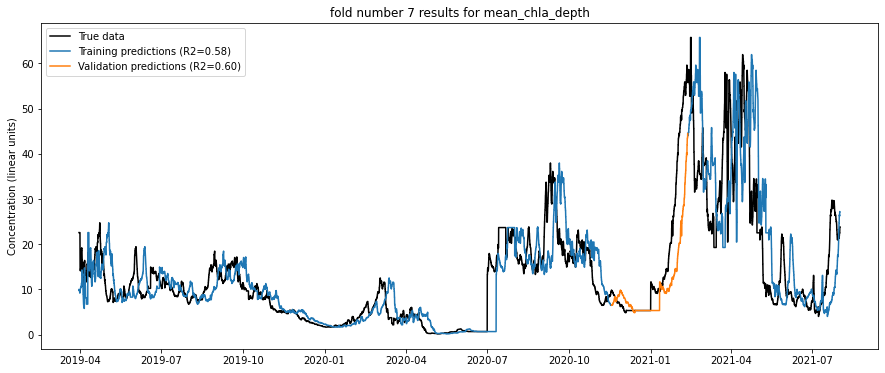

In [10]:
plot_fold(targets_tv,res,fold_id)

As stated in the notebook 1, the training set result is not a good metric to evaluate a model. A better visualisation is to only plot the validation of each fold:

In [6]:
def plot_val(targets_tv,res,targets_test=None,title='',scale='linear'):
    
    fig,axs = plt.subplots(len(targets_tv.keys()),figsize = (15,6*len(targets_tv.keys())))
    if len(targets_tv.keys())==1:
        axs=[axs]
    for idx,(ax,key) in enumerate(zip(axs,targets_tv.keys())):
        
        val_concat = np.concatenate([f['y_predv'] for f in res])
        
        artists = [ax.scatter(targets_tv.index,targets_tv[key].to_numpy(),s=1,c='k')]
        labels = ['True data']
        ax.set_title(f"{title} {key} (median R2={np.nanmedian([f['s_val']['R2_cat'][idx] for f in res]):.2f})")
        for fold in range(len(res[0]['bp'])-1):
            artists.append(ax.scatter(targets_tv.index[res[0]['bp'][fold]:res[0]['bp'][fold+1]],
                              res[fold]['y_predv'][:,idx],s=0.5))
            labels.append(f"Validation of fold {fold} (R2={res[fold]['s_val']['R2_cat'][idx]:.2f}))")
        if scale == 'linear':
            ax.set_ylabel("Concentration (linear units)")
        elif scale == 'log':
            ax.set_ylabel("Log concentration [log(c+1)]")
        ax.legend(artists,labels)
        if targets_test is not None:
            #the test predictions are not used for now
            #plot the mean and std of the test predictions
            #remove empty slice warning occuring when only nans are provided.
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)

                testres = np.array([resi['y_predte'] for resi in res])
                test_mean = np.nanmean(testres,axis=0)
                test_std = np.nanstd(testres,axis= 0)


            ax.scatter(targets_test.index,targets_test[key],c='k',s=1)
            ax.scatter(targets_test.index,test_mean[:,idx],s=0.5)
            ax.fill_between(targets_test.index,
                            test_mean[:,idx] - 1.96*test_std[:,idx],
                            test_mean[:,idx] + 1.96*test_std[:,idx],
                            color='gray', alpha=0.2)

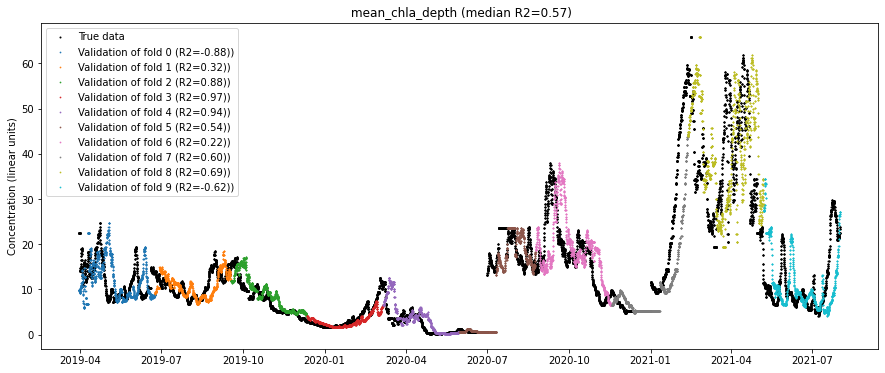

In [12]:
plot_val(targets_tv,res)

Another way of measuring the performance of a model is to see how the $R^2$ score decrease with an increase in lag: The general rule is that a simple model can get some good results in short term predictions due to the high autocorrelation, whereas a more complex one usually performs better on the long run, as it takes more informations into account. A function was then written to compare how the different models would behave:

In [13]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_2']
#chose a model
model = AR(out_keys,1)
#chose the number of folds
n_fold = 10


res_lag = []
tar_lag = []
for lag in lags:
    print(' '*100+f"lag {lag}/{lags[-1]}",end= '\r')
    inputs_tv = dftv[in_keys][:-24*lag]
    targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
    res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
    tar_lag.append(targets_tv)
    

In [7]:
def R2_vs_lag(lags,res_model:list,tar_data:list,title="R2 vs lags",model_names = None,train = False):
    keys = res_model[0][0][0]['outkeys']
    fig,axs = plt.subplots(1,len(keys),figsize=(len(keys)*5,4))
    if len(keys)==1:
        axs = [axs]
    if train:
        artists =np.empty((2*len(res_model),len(keys)),dtype=plt.Line2D)
    else:
        artists = np.empty((len(res_model),len(keys)),dtype=plt.Line2D)
    if len(tar_data)==1:
        tar_data = tar_data * len(res_model)
    for idx_model,(res_lag,tar_lag) in enumerate(zip(res_model,tar_data)):
        r2mean_lag = []
        r2mean_lag_train = []
        for res,tar in zip(res_lag,tar_lag):
            if train:
                r2mean_lag_train.append(np.nanmean([res_fold['s_train']['R2_cat'] for res_fold in res],axis=0))
            r2mean_lag.append(np.nanmean([res_fold['s_val']['R2_cat'] for res_fold in res],axis=0))
        r2mean_lag = np.array(r2mean_lag)
        r2mean_lag_train = np.array(r2mean_lag_train)
        fig.suptitle(title)
        for idx,(ax,key) in enumerate(zip(axs,keys)):
            if train:
                artists[len(res_model)+idx_model,idx] = ax.plot(lags,r2mean_lag_train[:,idx])[0]
            artists[idx_model,idx] = ax.plot(lags,r2mean_lag[:,idx])[0]
            ax.hlines(0,min(lags),max(lags),color='k',linestyle='dashed')
            ax.set_title(key)
            ax.set_xlabel("lag [day]")
            ax.set_ylabel("mean R2 over all folds")
            ax.set_ylim(max(-0.1,np.min(r2mean_lag[:,idx])-0.1),1)
    if model_names is not None:
        if train:
            model_namest = [model_name + " (on training)" for model_name in model_names]
            [ax.legend(artists[:,idx],model_names+model_namest) for idx,ax in enumerate(axs)]
        else:
            [ax.legend(artists[:,idx],model_names) for idx,ax in enumerate(axs)]
    plt.show()

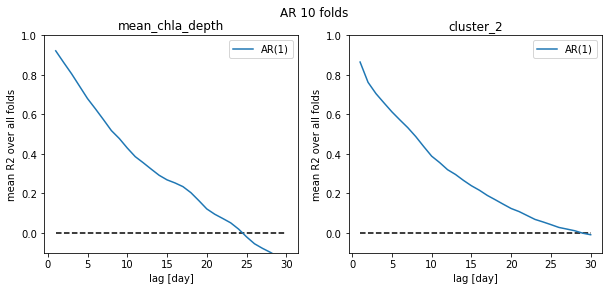

In [15]:
R2_vs_lag(lags,[res_lag],[tar_lag],title='AR 10 folds',model_names = ['AR(1)'])

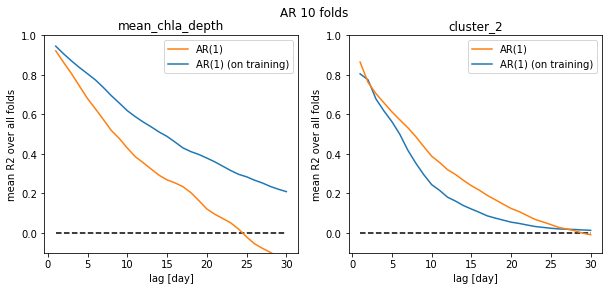

In [16]:
R2_vs_lag(lags,[res_lag],[tar_lag],title='AR 10 folds',model_names = ['AR(1)'],train=True)

One can wonder what the additional degree of freedom of an AR model add compared to a simple copy-past one. To explore this thoroughly, it is possible to examine the only parameter of the model over the different lags:

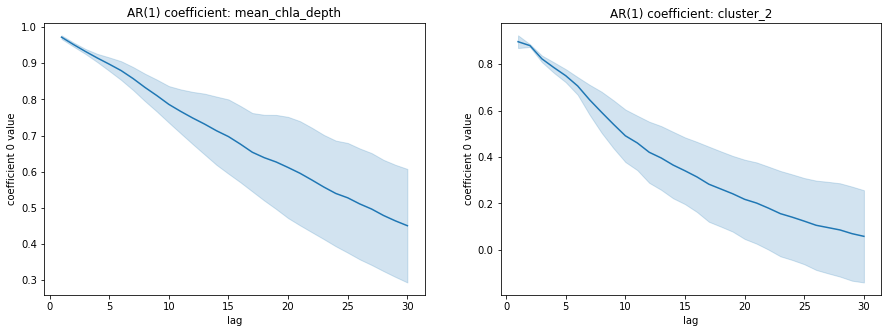

In [23]:
#check the value of the parameters:

fig,axs = plt.subplots(1,len(out_keys),figsize=(15,5))
if len(out_keys)==1:
    axs = [axs]

for i,key in enumerate(out_keys):

    coefs = np.array([[res_lag[lag][fold]['model'].skmodels[i].coef_ for fold in range(n_fold) ] for lag in range(30)])
    mean = np.mean(coefs,axis=1)
    std = np.std(coefs,axis=1)
    ax = axs[i]
    ax.plot(np.arange(1,maxlag+1),mean[:,idx_coef])
    ax.fill_between(np.arange(1,maxlag+1), mean[:,idx_coef] - 1.96*std[:,idx_coef], mean[:,idx_coef] + 1.96*std[:,idx_coef],
                     color='tab:blue', alpha=0.2)
    ax.set_xlabel("lag")
    ax.set_ylabel(f"coefficient {idx_coef} value")
    ax.set_title(f'AR(1) coefficient: {key}')

As this value monotonically decreasing, the prediction tends to 0 as the lag increase. Note that as the data is normalized, this means that the models reduce the importance of the local observation versus the global one. It can also be interestingly noted that as this behavior is stronger in the cluster 2 variable, the R2 score does not go in the negative, even at long lag. On the other hand, the higher coefficient of the chlorophyll a gets a better result at short lags, but can become worse than the mean over the training data in the longer settings

### Analysis of the hyper parameter:
The only hyper parameter of this model is the number of days that it takes into account. One can then already compare these different versions on the different metrics to optimize this value:

In [25]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_2']
#chose the models to compare
models = [AR(out_keys,1)]
models.append(AR(out_keys,5))
models.append(AR(out_keys,50))
models.append(AR(out_keys,100))
models.append(AR(out_keys,15*24))
models.append(AR(out_keys,1,CP=True))
models_name = ['AR(1)','AR(5)','AR(50)','AR(100)','AR(360)','CP']
#chose the number of folds
n_fold = 10


res_AR = []
for model,model_name in zip(models,models_name):
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
        tar_lag.append(targets_tv)
    res_AR.append(res_lag)

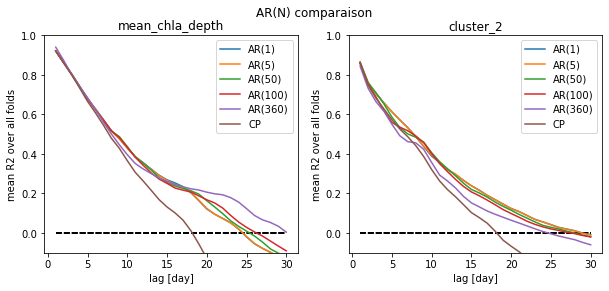

In [29]:
R2_vs_lag(lags,res_AR,[tar_lag],title='AR(N) comparaison',model_names = models_name)

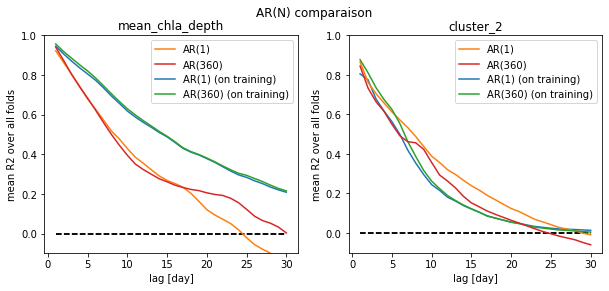

In [32]:
#compare the biggest model to the smallest one on training:
R2_vs_lag(lags,[res_AR[0],res_AR[-2]],[tar_lag],title='AR(N) comparaison',
          model_names = [models_name[0], models_name[-2]],train=True)

As one can see, a model of this scale can be relatively well described in a Markovian way: including more past data points does not change add a lot of information in the model. 

As the training score does not change, the models do not show sign of, and while the variation in the validation score is probably still in a confidence interval, the bigger model seem to be a bit more stable than AR(1)

One can also note that the copy-past model (CP) has roughly the same score as AR(1) in the short lags, but as it does not get advantage of the decreasing coefficient, it is getting linearly worse as time advances, while the AR(1) has more of an asymptotic decrease

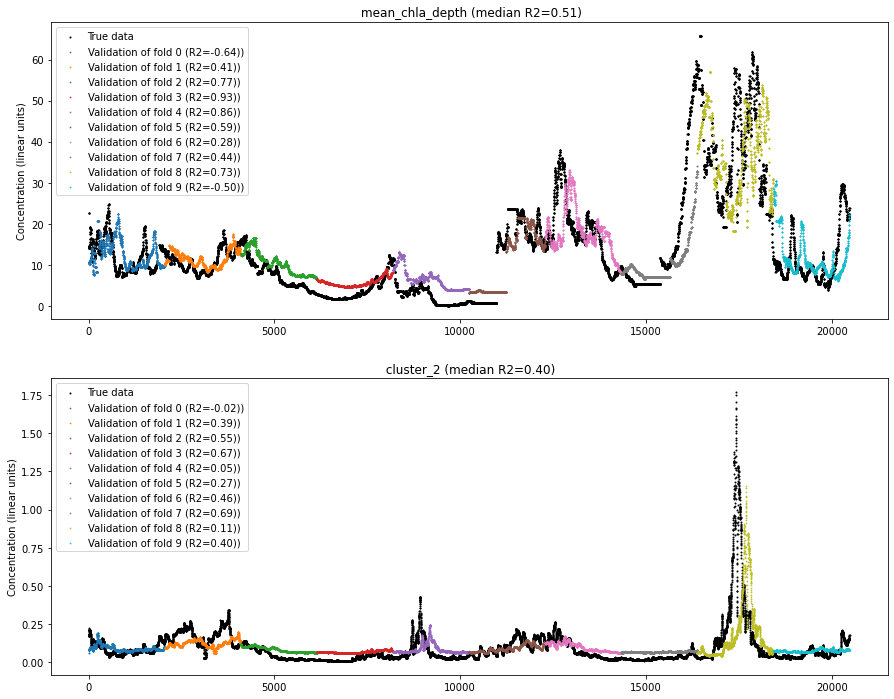

In [33]:
lag = 10
model_id = 0
plot_val(tar_lag[lag],res_AR[model_id][lag])

To see the influence of each parameters, one could examine each one of them in the biggest model, and compare them at the shortest and longest lag

In [39]:
#check the value of the parameters:
idx_coef = 0
idx_model = -2
lags = [1,29]
np.array([[res_AR[idx_model][lag][fold]['model'].skmodels[0].coef_ for fold in range(n_fold) ] for lag in lags]).shape

(2, 10, 360)

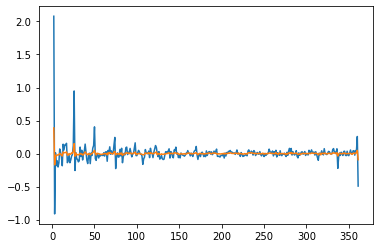

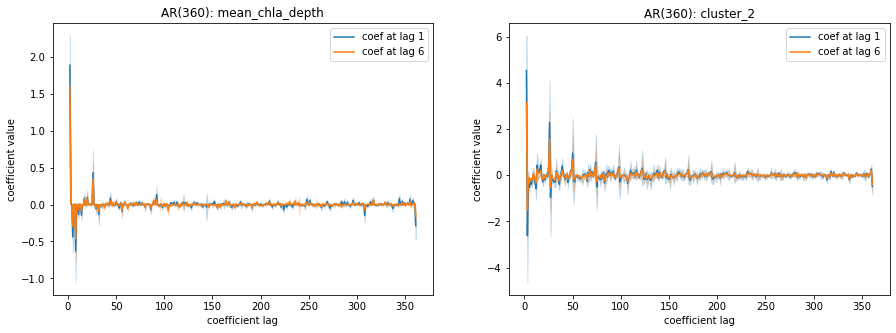

In [89]:
#check the value of the parameters:
idx_coef = 0
idx_model = -2
lags = [0,5]


fig,axs = plt.subplots(1,len(out_keys),figsize=(15,5))
colors = ['tab:blue','tab:orange']
if len(out_keys)==1:
    axs = [axs]

for i,key in enumerate(out_keys):
    ax = axs[i]
    coefs = np.array([[res_AR[idx_model][lag][fold]['model'].skmodels[i].coef_ for fold in range(n_fold) ] for lag in lags])
    mean = np.mean(coefs,axis=1)
    
    std = np.std(coefs,axis=1)
    ax.plot(np.arange(coefs.shape[2]+1,1,-1),mean[0:len(lags),:].T)
    for lag in range(len(lags)):
        ax.fill_between(np.arange(coefs.shape[2]+1,1,-1), mean[lag,:] - 1.96*std[lag,:], mean[lag,:]
                        + 1.96*std[lag,:],
                        color=colors[lag], alpha=0.2)
    ax.set_xlabel("coefficient lag")
    ax.set_ylabel(f"coefficient value")
    ax.set_title(models_name[idx_model]+": "+key)
    ax.legend([f"coef at lag {lag+1}" for lag in lags])


As one can see, the first coefficient has much higher value than any of the others. This bigger model is also able to approximate the derivative of the time series by using negative weights on the recent (yet not the last) coefficient. One can also note that there is a 24h regularity in the model, that might be due to the rolling average done on the target (confirmed in the notebook number 3). 

## Other models type
This basic autoregressive model was improved by allowing cross-correlations, making it a linear model:

$\hat{X}(t+l)=\sum_{i=0}^{i<k}\Phi_i X(t-i)$

Where $\Phi_i$ are matrices that do not need to be diagonal anymore. Said otherwise, the model now takes into account all of the explanatory variables:

In [8]:
class Linear:
    def __init__(self,target_keys:list,k):
        
        #for the implementation, a different model is used for each variables:
        self.skmodels = [LinearRegression() for _ in target_keys]
        self.k = k
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.idxtarget = []
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        self._scalerout = self._scalerout.fit(target.values)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target.values)
        ntar = np.nan_to_num(ntar)
        for idx,target in enumerate(self.target_keys):
            #stack the input variable so that k points are given for each target:
            x = np.zeros((len(inputs)-self.k+1,self.k*len(inputs.keys())))
            for i in range(self.k):
                for j in range(len(inputs.keys())):
                    x[:,i*len(inputs.keys())+j] = ninp[i:len(inputs)-self.k+1+i,j]
            y = ntar[self.k-1:,idx]
            self.skmodels[idx].fit(x,y)
    def pred(self,inputs,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = np.empty((len(inputs),len(self.target_keys)))
        npred[:,:] = np.nan
        for idx,target in enumerate(self.target_keys):
            x = np.zeros((len(inputs)-self.k+1,self.k*len(inputs.keys())))
            for i in range(self.k):
                for j in range(len(inputs.keys())):
                    x[:,i*len(inputs.keys())+j] = ninp[i:len(inputs)-self.k+1+i,j]
            npred[self.k-1:,idx] = self.skmodels[idx].predict(x)
        return self._scalerout.inverse_transform(npred)   

In [91]:
# setup the training:
#chose a lag
lag = 10

#explanatory variables
inputs_tv = dftv[:-24*lag]
# target variables to predict 
target_keys = ['mean_chla_depth']
targets_tv = dftv[24*lag:][target_keys]

#chose a model
model = Linear(target_keys,1)


#run the kfold
n_fold = 10
#run the kfold (while keeping the same parameters as before)
res = kf.kfold(model,inputs_tv,targets_tv,n_fold)
print("Model trained"+' '*70)

Model trained                                                                                       


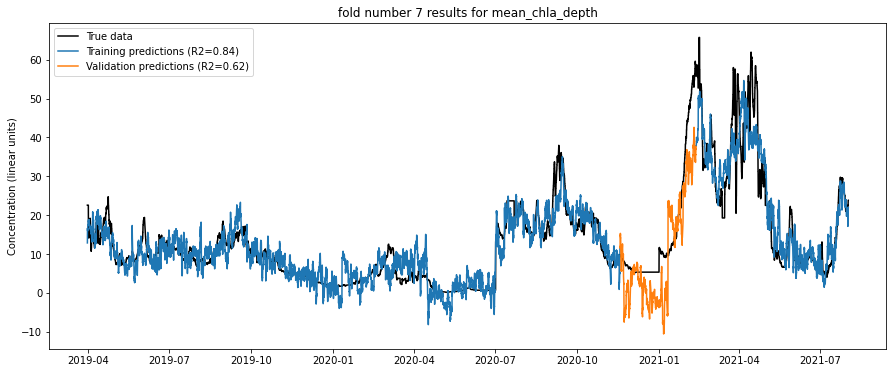

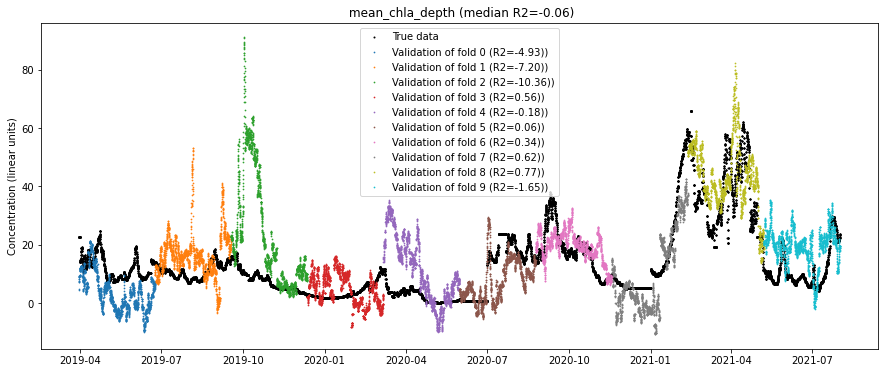

In [92]:
plot_fold(targets_tv,res,fold_id)
plot_val(targets_tv,res)

As one can already see on this single example, this model is quickly prone to over fitting. To get a more quantitative idea, it was compared to the AR model at different lags:

In [93]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_2']
#chose the models to compare
models = [Linear(out_keys,1)]
models.append(Linear(out_keys,2))
models.append(AR(out_keys,1))
models_name = ['Linear(1)','Linear(2)','AR(1)']
#chose the number of folds
n_fold = 10


res_model = []
for model,model_name in zip(models,models_name):
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
        tar_lag.append(targets_tv)
    res_model.append(res_lag)

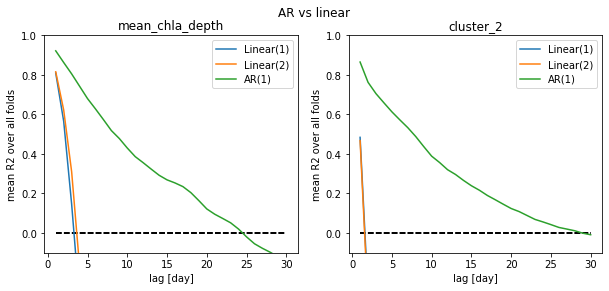

In [94]:
R2_vs_lag(lags,res_model,[tar_lag],title='AR vs linear',model_names = models_name)

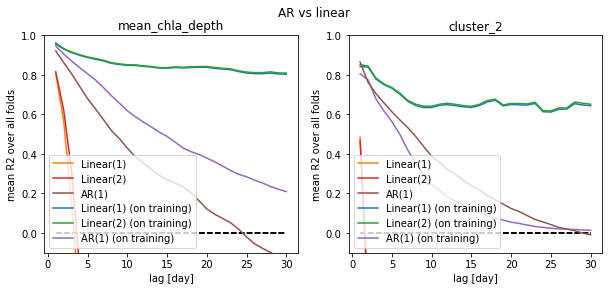

In [95]:
R2_vs_lag(lags,res_model,[tar_lag],title='AR vs linear',model_names = models_name,train=True)

As one can see, adding this additional information is highly detrimental to the validation score. The better score on the training set, on the other hand, shows that the model is over fitting, and that some regularization methods can be used to improve it. Note also that the linear model, as shown in the previous notebook, is highly influenced by the amount of data points it has for its training, and as new data is available as the time goes by, these models have a way better improvement potential. Meanwhile, regularization method can be tested.

### Lasso model
Lasso (least absolute shrinkage and selection operator) based models are using a L1 penalty on all of their trainable parameters: instead of finding 

$min_\Phi((F(X, \Phi)-Y)^2)$

Where X is the past variables, $\Phi$ the parameters and Y the future that we want to predict, the new objective of the optimization is now

$min_\Phi((F(X, \Phi)-Y)^2+\alpha|\Phi|)$

where $\alpha$ is a hyper parameter determining the strength of the penalty. This method have two advantages: First, it reduce the flexibility of the model, making it less probable to end up with some extreme values in the parameters, and thus reducing the influence of small variations. Second, the specificity of the L1 penalty in regard to the more common L2, is that it will strongly reduce the small parameters, or said otherwise, it will set the importance of all (nearly) useless variables at 0, and by checking the remaining non-zero coefficient, one can then interpret them more easily.


In [9]:
class Lasso:
    def __init__(self,target_keys:list,k, **lasso_kwarg):
        from sklearn.linear_model import Lasso
        from sklearn.preprocessing import StandardScaler
        self.skmodels = [Lasso(**lasso_kwarg) for _ in target_keys]
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.target_keys = target_keys
        self.k = k
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        target = target.to_numpy()
        self._scalerout = self._scalerout.fit(target)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target)
        isnan = np.isnan(ntar);
        ntar = np.nan_to_num(ntar)
        #stack the input variable so that k points are given for each target:
        x = np.zeros((len(inputs)-self.k+1,self.k*len(inputs.keys())))
        for keyid in range(len(self.target_keys)):
            for i in range(self.k):
                for j in range(len(inputs.keys())):
                    x[:,i*len(inputs.keys())+j] = ninp[i:len(inputs)-self.k+1+i,j]
            y = ntar[self.k-1:,keyid]
            w = ~isnan[self.k-1:,keyid]
            self.skmodels[keyid].fit(x,y,sample_weight=w)
    def pred(self,inputs,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = np.empty((len(inputs),len(self.target_keys)))
        npred[:,:] = np.nan
        for idx,target in enumerate(self.target_keys):
            x = np.zeros((len(inputs)-self.k+1,self.k*len(inputs.keys())))
            for i in range(self.k):
                for j in range(len(inputs.keys())):
                    x[:,i*len(inputs.keys())+j] = ninp[i:len(inputs)-self.k+1+i,j]
            if npred.shape[1]==1:
                npred[self.k-1:]=np.expand_dims(self.skmodels[idx].predict(x),-1)
            else:
                npred[self.k-1:,idx] = self.skmodels[idx].predict(x)
        return self._scalerout.inverse_transform(npred)

To explore the influence of the L1 regularizer, different values of $\alpha$ were tested, while keeping the lag at 10 days, so the prediction should not only rely on the last chlorophyll a measurement:

In [107]:
#lag to fit the models to
lag = 10

#input keys
in_keys = dftv.keys()
#number of time step taken as input
k = 2
#output keys 
out_keys= ['mean_chla_depth','cluster_2']
#chose the models to compare
models = [Lasso(out_keys,k,alpha = 0.01,max_iter=50000)]
models.append(Lasso(out_keys,k,alpha = 0.05,max_iter=50000))
models.append(Lasso(out_keys,k,alpha = 0.1,max_iter=50000))
models.append(Lasso(out_keys,k,alpha = 0.5,max_iter=50000))
models.append(Lasso(out_keys,k,alpha = 1,max_iter=500000))
models.append(Lasso(out_keys,1,alpha = 0.01,max_iter=50000))
models.append(Lasso(out_keys,1,alpha = 0.05,max_iter=50000))
models.append(Lasso(out_keys,1,alpha = 0.1,max_iter=50000))
models.append(Lasso(out_keys,1,alpha = 0.5,max_iter=50000))
models.append(Lasso(out_keys,1,alpha = 1,max_iter=50000))
models_name = ['k=2\nalpha=0.01','k=2\nalpha=0.05',
               'k=2\nalpha=0.1','k=2\nalpha=0.5','k=2\nalpha = 1',
               'k=1\nalpha=0.01','k=1\nalpha=0.05',
               'k=1\nalpha=0.1','k=1\nalpha=0.5','k=1\nalpha = 1',]
#chose the number of folds
n_fold = 10


res_LASSO = []
for model,model_name in zip(models,models_name):
    inputs_tv = dftv[in_keys][:-24*lag]
    targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
    res_LASSO.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
tar_lag = targets_tv


In [118]:
score = np.zeros((len(models),n_fold,len(out_keys)))
for model_idx in range(len(models)):
    score[model_idx,:,:] = np.array([res_LASSO[model_idx][fold]['s_val']['R2_cat'] for fold in range(10)])
score.shape

(10, 10, 2)

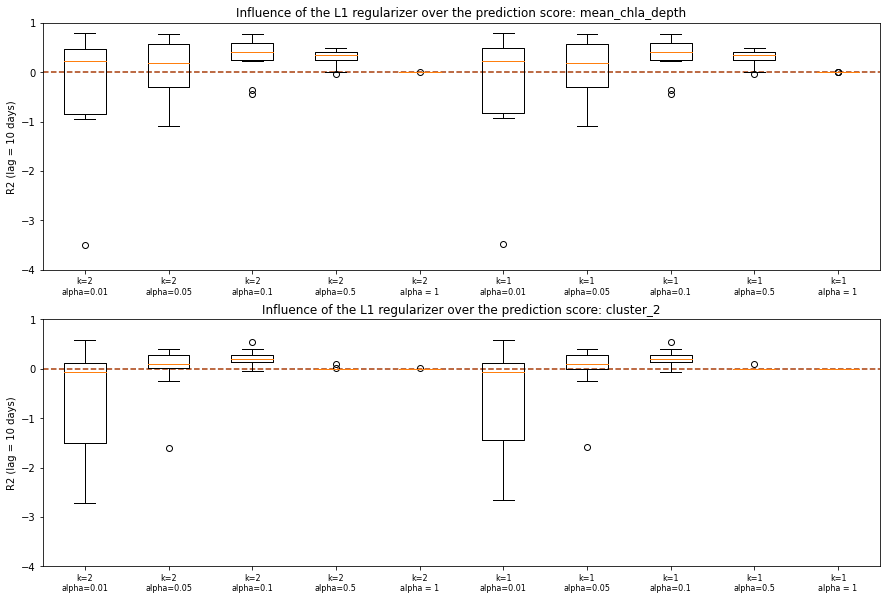

In [136]:
#plot a boxplot of the validation result of each model:
score = np.zeros((len(models),n_fold,len(out_keys)))
for model_idx in range(len(models)):
    score[model_idx,:,:] = np.array([res_LASSO[model_idx][fold]['s_val']['R2_cat'] for fold in range(10)])
fig,axs = plt.subplots(len(out_keys),1,figsize=(15,5*len(out_keys)))
if len(out_keys)==1:
    axs = [axs]
for i,key in enumerate(out_keys):
    ax = axs[i]
    ax.boxplot(score[:,:,i].T)
    ax.set_xticklabels(models_name,fontsize=8)
    ax.set_ylim([-4,1])
    ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
    ax.set_title(f"Influence of the L1 regularizer over the prediction score: {key}")
    ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
plt.show()

One could also check the relationship between the $R^2$ coefficient and the number of used parameter:

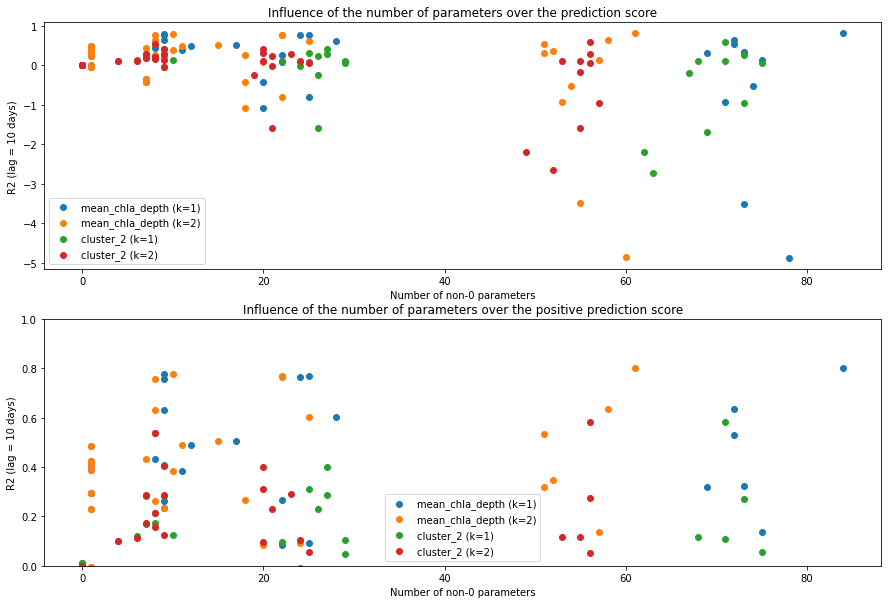

In [145]:
n_param = np.zeros((len(models),len(out_keys),n_fold))

for model_idx in range(len(models)):
    
    n_param[model_idx,:,:] = np.array([[np.sum(res_LASSO[model_idx][fold]['model'].skmodels[keyidx].coef_ != 0)
                                     for fold in range(10)] for keyidx in range(len(out_keys))])

fig,axs = plt.subplots(2,1,figsize=(15,10))
art_all = []
art_pos = []
for idx_key,key in enumerate(out_keys):
    ax = axs[0]
    art_all.append(ax.scatter(n_param[:len(models)//2,idx_key,:],score[:len(models)//2,:,idx_key]))
    art_all.append(ax.scatter(n_param[len(models)//2:,idx_key,:],score[len(models)//2:,:,idx_key]))
    #ax.set_xticklabels(models_name)
    #ax.set_ylim([-1,1])
    #ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
    
    ax = axs[1]
    art_pos.append(ax.scatter(n_param[:len(models)//2,idx_key,:],score[:len(models)//2,:,idx_key]))
    art_pos.append(ax.scatter(n_param[len(models)//2:,idx_key,:],score[len(models)//2:,:,idx_key]))
#ax.set_xticklabels(models_name)
ax = axs[0]
ax.set_title("Influence of the number of parameters over the prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
ax.set_xlabel("Number of non-0 parameters")
ax.legend(art_all,[key + k for key in out_keys for k in [" (k=1)"," (k=2)"]])

ax = axs[1]
ax.set_ylim([0,1])
ax.set_title("Influence of the number of parameters over the positive prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
ax.set_xlabel("Number of non-0 parameters")
ax.legend(art_pos,[key + k for key in out_keys for k in [" (k=1)"," (k=2)"]])
plt.show()

These observations highlight some fact about the data:
- The more a model has parameters, the bigger the variance of the results can be: a model that is not using any parameters (as do the ones with $\alpha=1$ or $\alpha=2$) will always have a $R^2$ score of 0.
- The $R^2$ metric is not symmetric: As the best result is one and the worst is not bounded, false positive prediction of HAB are highly detrimental to the global score. Using some aggregation resilient to outliers, such as taking the median of the $R^2$ over the folds, rather than the mean, can be a better representation of the model capability
- Even on the successful folds (with a $R^2$ score above 0), adding some parameters does not seem to improve the results by a lot after around 10 parameters. 
- Increasing the number of time step does not seem to improve the result. It can be easily explained by the high correlation between subsequent points

Another analysis that can be made is to check which parameter are used in each folds, and if their are present throughout each of them or in only a few.

In [152]:
inkeys = dftv.keys()
outkeys = ['mean_chla_depth','cluster_2']
lag = 10
model = Lasso(outkeys,1,alpha = 0.1,max_iter=50000)
n_fold = 10


inputs_tv = dftv[inkeys][:-24*lag]
targets_tv = dftv[outkeys][24*lag:].reset_index(drop=True)
res = kf.kfold(model,inputs_tv,targets_tv,n_fold)

In [157]:
param_idx = np.zeros((len(in_keys),len(out_keys)))
for outidx in range(len(out_keys)):
    for fold in range(n_fold):
        abscoefs = np.abs(res[fold]['model'].skmodels[outidx].coef_)
        non_zero = np.where(abscoefs !=0)[0]
        param_idx[non_zero,outidx]+=1 #add a count

In [163]:
for idxout, out_key in enumerate(out_keys):
    print(f"For the forecasting of {out_key}, the following key were \nused in the following proportion of the folds:")
    idx_used = np.where(param_idx[:,idxout] != 0)[0]
    for idx in idx_used:
        print(f"    {in_keys[idx]}: {int(param_idx[idx,idxout])}/{n_fold}")

For the forecasting of mean_chla_depth, the following key were 
used in the following proportion of the folds:
    mean_ph_depth: 2/10
    mean_chla_depth: 10/10
    mean_turb_depth: 7/10
    precipitation_tot_GR: 7/10
    windspeed_max_GR: 8/10
    Nitrit: 1/10
    Ammonium: 3/10
    mixed_layer_depth: 1/10
    eudiaptomus: 5/10
    kellikottia: 9/10
    nauplius: 5/10
    polyarthra: 1/10
    fragilaria: 1/10
    cluster_2: 8/10
    cluster_3: 3/10
    cluster_4: 1/10
    diatom: 1/10
    year: 10/10
    month: 2/10
For the forecasting of cluster_2, the following key were 
used in the following proportion of the folds:
    mean_o2ppm_depth: 1/10
    mean_ph_depth: 1/10
    cv_ph: 1/10
    mean_turb_depth: 10/10
    mean_global_radiation: 1/10
    rel_air_humidity_max_GR: 4/10
    windspeed_max_GR: 9/10
    Nitrat: 5/10
    Nitrit: 1/10
    thermocline: 2/10
    schmidt_stability: 1/10
    mixed_layer_depth: 2/10
    eudiaptomus: 1/10
    kellikottia: 9/10
    rotifers: 1/10
    cyclo

One can note that both variables use most of the same predictors. The fact that the year is used is showing that that temperature alone cannot fully describe the seasonality, so a periodic embedding will be used in the next notebook.

### Comparing LASSO & AR

In [10]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1,3)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_2']
#chose the models to compare
models = [Lasso(out_keys,1,alpha = 0.1,max_iter=50000)]
models.append(Lasso(out_keys,12,alpha = 0.1,max_iter=50000))
models.append(AR(out_keys,360))
models_name = ['Lasso(1)','Lasso(12)','AR(360)']
#chose the number of folds
n_fold = 10


res_model = []
for model,model_name in zip(models,models_name):
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
        tar_lag.append(targets_tv)
    res_model.append(res_lag)

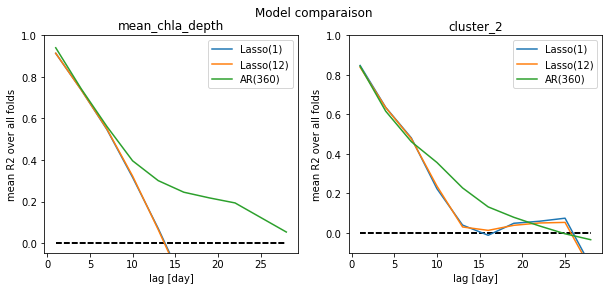

In [166]:
R2_vs_lag(lags,res_model,[tar_lag],title='Model comparaison',model_names = models_name,train=False)

Due to the high correlation between the subsequent data points, the next model tries to sample the inputs data at a lower frequency, allowing to use less correlated points without multiplying the number of parameters.

In [25]:
class Sparse:
    def __init__(self,target_keys:list,k, freq):
        
        #for the implementation, a different model is used for each variables:
        self.skmodels = [LinearRegression() for _ in target_keys]
        self.kf = k*freq
        self.k = k
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.freq = freq
        self.idxtarget = []
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        self._scalerout = self._scalerout.fit(target.values)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target.values)
        ntar = np.nan_to_num(ntar)
        for idx,target in enumerate(self.target_keys):
            #stack the input variable so that k points are given for each target:
            x = np.zeros((len(inputs)-self.kf+self.freq,self.k*len(inputs.keys())))
            for i in range(0,self.k):
                for j in range(len(inputs.keys())):
                    x[:,i*len(inputs.keys())+j] = ninp[i:len(inputs)-self.kf+self.freq+i,j]
            y = ntar[self.kf-self.freq:,idx]
            self.skmodels[idx].fit(x,y)
    def pred(self,inputs,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = np.empty((len(inputs),len(self.target_keys)))
        npred[:,:] = np.nan
        for idx,target in enumerate(self.target_keys):
            x = np.zeros((len(inputs)-self.kf+self.freq,self.k*len(inputs.keys())))
            for i in range(0,self.k):
                for j in range(len(inputs.keys())):
                    x[:,i*len(inputs.keys())+j] = ninp[i*self.freq:len(inputs)-self.kf+self.freq+i*self.freq,j]
            npred[self.kf-self.freq:,idx] = self.skmodels[idx].predict(x)
        return self._scalerout.inverse_transform(npred)   

In [133]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','cluster_2']
#chose the models to compare
models = [Linear(out_keys,2)]
models.append(Sparse(out_keys,2,24))
models.append(Sparse(out_keys,2,48))
models.append(Sparse(out_keys,2,240))


#models.append(AR(out_keys,1))
models_name = ['Linear(2)','Sparse(2,24)','Sparse(2,48)','Sparse(2,240)']#,'AR(1)']
#chose the number of folds
n_fold = 10


res_model = []
for model,model_name in zip(models,models_name):
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
        tar_lag.append(targets_tv)
    res_model.append(res_lag)

In [ ]:
R2_vs_lag(lags,res_model,[tar_lag],title='Model comparaison',model_names = models_name,train=True)

As one could have thought, as the model was already over fitting with only a single point, adding more data points does not increase the performance, even more as the correlation between the different inputs decrease. On the other hand, this modification of the linear model can be extended to the LASSO one, or to any other model. 

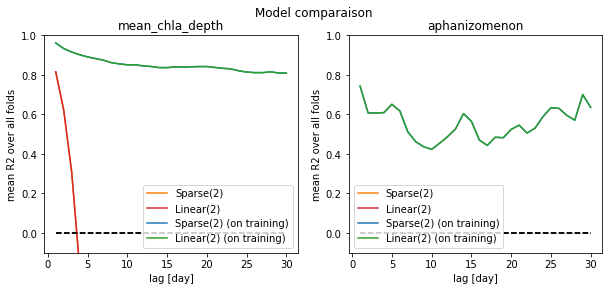

In [129]:
R2_vs_lag(lags,res_model,[tar_lag],title='Model comparaison',model_names = models_name,train=True)

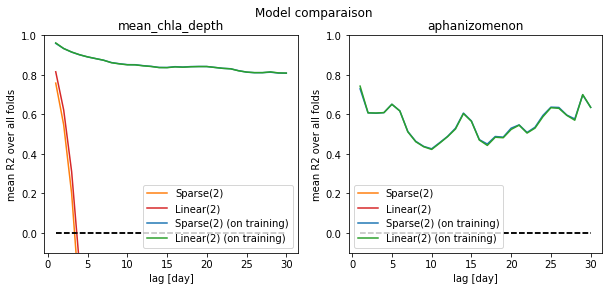

In [131]:
R2_vs_lag(lags,res_model,[tar_lag],title='Model comparaison',model_names = models_name,train=True)

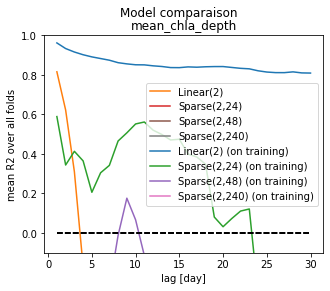

In [136]:
R2_vs_lag(lags,res_model,[tar_lag],title='Model comparaison',model_names = models_name,train=True)

### L2 Regularization 
As a L1 regularizer can be described as

$min_\Phi((F(X, \Phi)-Y)^2+\alpha_1|\Phi|)$

A L2 regularizer would be 

$min_\Phi((F(X, \Phi)-Y)^2+\alpha_2|\Phi|^2)$

The key difference between the two is that the L2 regularizer proportionally affect bigger weights more, in such a way that the model rely on a more diverse set of variable rather than only a few.

In practice, when both regularizers are used the hyperparameters $\alpha_1$ and $\alpha_2$ are not often used, and the notation

$min_\Phi((F(X, \Phi)-Y)^2+\alpha(\beta|\Phi| + (1-\beta)|\Phi|^2))$

This is the notation used in the later model: Elastic net. Note that this implementation will be directly used to test both the L2 regularizer alone (by setting $\beta$ to 0) and to do a more general hyper parameter search. 






In [151]:
class ElastNet:
    def __init__(self,target_keys:list,k, freq=1,**elast_kwarg):
        from sklearn.linear_model import ElasticNet

        #for the implementation, a different model is used for each variables:
        self.skmodel = ElasticNet(**elast_kwarg)
        self.kf = k*freq
        self.k = k
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.freq = freq
        self.idxtarget = []
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        self._scalerout = self._scalerout.fit(target.values)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target.values)
        ntar = np.nan_to_num(ntar)
        #stack the input variable so that k points are given for each target:
        x = np.zeros((len(inputs)-self.kf+self.freq,self.k*len(inputs.keys())))
        for i in range(0,self.k):
            for j in range(len(inputs.keys())):
                x[:,i*len(inputs.keys())+j] = ninp[i:len(inputs)-self.kf+self.freq+i,j]
        y = ntar[self.kf-self.freq:,:]
        self.skmodel.fit(x,y)
    def pred(self,inputs,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = np.empty((len(inputs),len(self.target_keys)))
        npred[:,:] = np.nan
        x = np.zeros((len(inputs)-self.kf+self.freq,self.k*len(inputs.keys())))
        for i in range(0,self.k):
            for j in range(len(inputs.keys())):
                x[:,i*len(inputs.keys())+j] = ninp[i*self.freq:len(inputs)-self.kf+self.freq+i*self.freq,j]
        if npred.shape[1]==1:
            npred[self.kf-self.freq:]=np.expand_dims(self.skmodel.predict(x),-1)
        else:
            npred[self.kf-self.freq:,:] = self.skmodel.predict(x)
        return self._scalerout.inverse_transform(npred)   

This model can be a better test bed to see the effect of a lower sampling frequency. To keep the computation time in control, and given the previous results, only two time step will be used in each test. 

In [164]:
#lag to fit the models to
lag = 10
 
#input keys
in_keys = dftv.keys()
#number of time step taken as input
k = 2
#output keys 
out_keys= ['mean_chla_depth']
#chose the models to compare
models_base = [ElastNet(out_keys,k,freq = 1,alpha = 0.01,l1_ratio = 0.5,max_iter=50000)]
models_base.append(ElastNet(out_keys,k,freq = 1,alpha = 0.05,l1_ratio = 0.5,max_iter=50000))
models_base.append(ElastNet(out_keys,k,freq = 1,alpha = 0.1,l1_ratio = 0.5,max_iter=50000))
models_base.append(ElastNet(out_keys,k,freq = 1,alpha = 0.5,l1_ratio = 0.5,max_iter=50000))
models_base.append(ElastNet(out_keys,k,freq = 1,alpha = 1,l1_ratio = 0.5,max_iter=50000))
models_sparse = [ElastNet(out_keys,k,freq = 120,alpha = 0.01,l1_ratio = 0.5,max_iter=50000)]
models_sparse.append(ElastNet(out_keys,k,freq = 120,alpha = 0.05,l1_ratio = 0.5,max_iter=50000))
models_sparse.append(ElastNet(out_keys,k,freq = 120,alpha = 0.1,l1_ratio = 0.5,max_iter=50000))
models_sparse.append(ElastNet(out_keys,k,freq = 120,alpha = 0.5,l1_ratio = 0.5,max_iter=50000))
models_sparse.append(ElastNet(out_keys,k,freq = 120,alpha = 1,l1_ratio = 0.5,max_iter=50000))


models_base_name = ['freq=1\nalpha=0.01','freq=1\nalpha=0.05',
                    'freq=1\nalpha=0.1','freq=1\nalpha=0.5','freq=1\nalpha = 1']
models_sparse_name = ['freq=120\nalpha=0.01','freq=120\nalpha=0.05',
                    'freq=120\nalpha=0.1','freq=120\nalpha=0.5','freq=120\nalpha = 1']
                    
models = models_base + models_sparse

#chose the number of folds
n_fold = 10


res_model_full = []
for model in models:
    inputs_tv = dftv[in_keys][:-24*lag]
    targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
    res_model_full.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
tar_lag = targets_tv

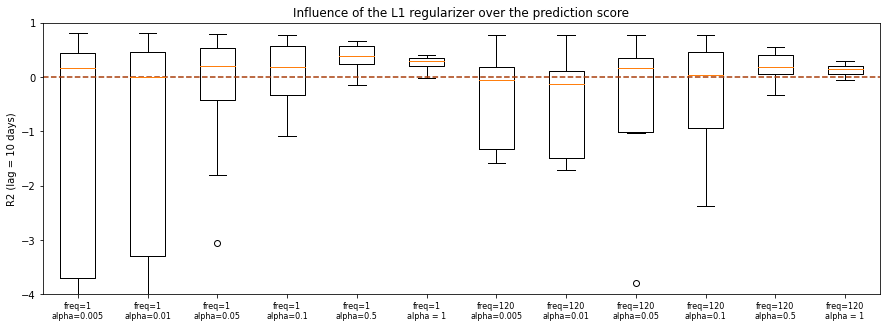

In [170]:
#plot a boxplot of the validation result of each model:
score = np.zeros((len(models),n_fold))
for model_idx in range(len(models)):
    score[model_idx,:] = np.array([res_model_full[model_idx][fold]['s_val']['R2'] for fold in range(10)])
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.boxplot(score.T)
ax.set_xticklabels(models_base_name+models_sparse_name,fontsize=8)
ax.set_ylim([-4,1])
ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
ax.set_title("Influence of the L1 regularizer over the prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
plt.show()

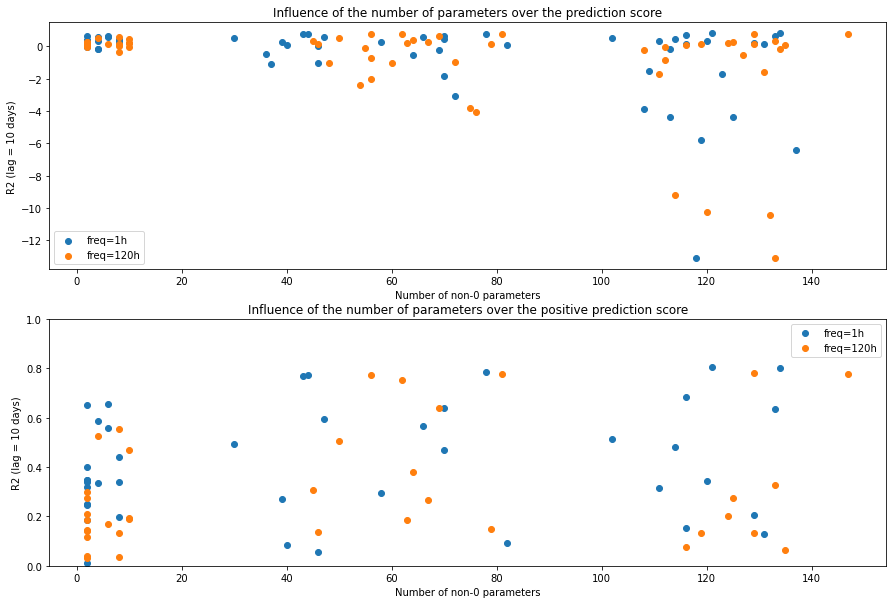

In [171]:
n_param = np.zeros((len(models),n_fold))
for model_idx in range(len(models)):
    n_param[model_idx,:] = np.array([np.sum(res_model_full[model_idx][fold]['model'].skmodel.coef_ != 0) for fold in range(10)])

fig,axs = plt.subplots(2,1,figsize=(15,10))
ax = axs[0]
freq1 = ax.scatter(n_param[:len(models)//2,:],score[:len(models)//2,:])
freq24 = ax.scatter(n_param[len(models)//2:,:],score[len(models)//2:,:])
#ax.set_xticklabels(models_name)
#ax.set_ylim([-1,1])
#ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
ax.set_title("Influence of the number of parameters over the prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
ax.set_xlabel("Number of non-0 parameters")
ax.legend([freq1,freq24],["freq=1h","freq=120h"])
ax = axs[1]
freq1 = ax.scatter(n_param[:len(models)//2,:],score[:len(models)//2,:])
freq24 = ax.scatter(n_param[len(models)//2:,:],score[len(models)//2:,:])
#ax.set_xticklabels(models_name)
ax.set_ylim([0,1])
#ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
ax.set_title("Influence of the number of parameters over the positive prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
ax.set_xlabel("Number of non-0 parameters")
ax.legend([freq1,freq24],["freq=1h","freq=120h"])
plt.show()

The effect of a lower frequency twofold: first, at high regularization, the result is generally worse, whereas the at low regularization the number of parameter used is generally higher and the result similar. 

In [168]:
#also try to increase the value of L2 in respect of L1
models_l2 =     [ElastNet(out_keys,k,freq = 120,alpha = 0.005,l1_ratio = 0.7,max_iter=50000)]
models_l2.append(ElastNet(out_keys,k,freq = 120,alpha = 0.01, l1_ratio = 0.7,max_iter=50000))
models_l2.append(ElastNet(out_keys,k,freq = 120,alpha = 0.05, l1_ratio = 0.7,max_iter=50000))
models_l2.append(ElastNet(out_keys,k,freq = 120,alpha = 0.1,  l1_ratio = 0.7,max_iter=50000))
models_l2.append(ElastNet(out_keys,k,freq = 120,alpha = 0.5,  l1_ratio = 0.7,max_iter=50000))
models_l2.append(ElastNet(out_keys,k,freq = 120,alpha = 1,    l1_ratio = 0.7,max_iter=50000))
res_model_l2 = []
for model in models_l2:
    inputs_tv = dftv[in_keys][:-24*lag]
    targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
    res_model_l2.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))

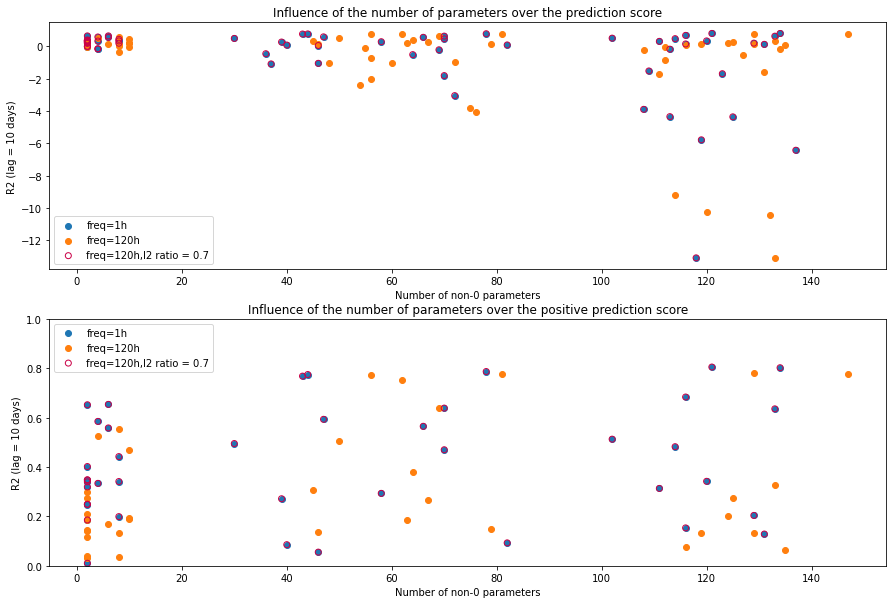

In [182]:
n_param_l2 = np.zeros((len(models_l2),n_fold))
score_l2 = np.zeros((len(models_l2),n_fold))
for model_idx in range(len(models_l2)):
    score_l2[model_idx,:] = np.array([res_model_full[model_idx][fold]['s_val']['R2'] for fold in range(10)])    
    n_param_l2[model_idx,:] = np.array([np.sum(res_model_full[model_idx][fold]['model'].skmodel.coef_ != 0) for fold in range(10)])

fig,axs = plt.subplots(2,1,figsize=(15,10))
ax = axs[0]
freq1 = ax.scatter(n_param[:len(models)//2,:],score[:len(models)//2,:])
freq120 = ax.scatter(n_param[len(models)//2:,:],score[len(models)//2:,:])
freq120l2 = ax.scatter(n_param_l2,score_l2,edgecolors='xkcd:ruby',facecolor='none')
#ax.set_xticklabels(models_name)
#ax.set_ylim([-1,1])
#ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
ax.set_title("Influence of the number of parameters over the prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
ax.set_xlabel("Number of non-0 parameters")
ax.legend([freq1,freq24,freq120l2],["freq=1h","freq=120h","freq=120h,l2 ratio = 0.7"])
ax = axs[1]
freq1 = ax.scatter(n_param[:len(models)//2,:],score[:len(models)//2,:])
freq120 = ax.scatter(n_param[len(models)//2:,:],score[len(models)//2:,:])
freq120l2 = ax.scatter(n_param_l2,score_l2,edgecolors='xkcd:ruby',facecolor='none')
#ax.set_xticklabels(models_name)
ax.set_ylim([0,1])
#ax.hlines(0,0.5,len(models)+0.5,linestyle = "dashed",color="xkcd:rust")
ax.set_title("Influence of the number of parameters over the positive prediction score")
ax.set_ylabel("R2 (lag = "+str(lag)+" days)")
ax.set_xlabel("Number of non-0 parameters")
ax.legend([freq1,freq24,freq120l2],["freq=1h","freq=120h","freq=120h,l2 ratio = 0.7"])
plt.show()

As one can see, increasing the L2 ratio makes the point indistinguishable from the model using a frequency of one hour. The reason why is simple: the input coming from 120 hours earlier are simply ignored. 

### Estimating the optimal number of inputs
A method often used in auto regression to estimate the optimal parameter k is to use the autocorrelation function, and to say that below a certain threshold the data is useless. This method would allow a tremendous gain of speed in the training of the models: This would allow to set a reasonable bound on the number of points. Moreover, it could be used to select a different number of points of the different explanatory variables, and even to not use the worst ones at all. 

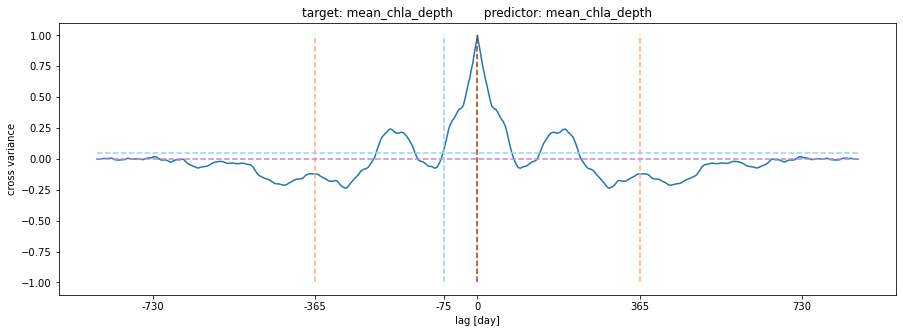

In [207]:
target = 'mean_chla_depth'
predictor = 'mean_chla_depth'

threshold = 0.05
######################################################


margin = 200 #doesnt plot the autocorrelation in the margin


dfci = dftv-dftv.mean()
dfci = dfci.fillna(0)

fig,ax = plt.subplots(figsize=(15,5))
crosscor = signal.correlate(dfci[target],dfci[predictor], mode='full').astype(float)
lags = signal.correlation_lags(len(dfci[target]), len(dfci[predictor]), mode='full')
crosscor /=dfci[target].std()*dfci[predictor].std()*len(dfci[target])

ax.plot(lags[margin:-margin],crosscor[margin:-margin])
for k in range(-2+1,2):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k*24, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,lags[margin],lags[-margin],linestyles='dashed',color='xkcd:pale purple')
ax.hlines(threshold,lags[margin],lags[-margin],linestyles='dashed',color='xkcd:light blue')

marker = 75
ax.vlines(-marker*24,-1,1,linestyle='dashed',color='xkcd:light blue')

ax.set_xticks(np.append(np.linspace(-365*2*24,365*2*24,5),-marker*24))
ax.set_xticklabels(np.append(np.linspace(-365*2,365*2,5,dtype=int),-marker))

ax.set_title("target: "+target+"        predictor: "+predictor)
ax.set_xlabel('lag [day]')
ax.set_ylabel('cross variance')
plt.show()

The auto- (and cross-) correlations function can also be used to adapt the frequency: By removing the influence of the most correlated point, and only using the marginal variation to pick the next one.

In [220]:
dftv.keys()

Index(['mean_temp_depth', 'cv_temp', 'mean_condF_depth', 'cv_condF',
       'mean_o2_depth', 'cv_o2', 'mean_o2ppm_depth', 'cv_o2ppm',
       'mean_ph_depth', 'cv_ph',
       ...
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'diatom', 'ciliate',
       'year', 'month', 'day', 'hour'],
      dtype='object', length=106)

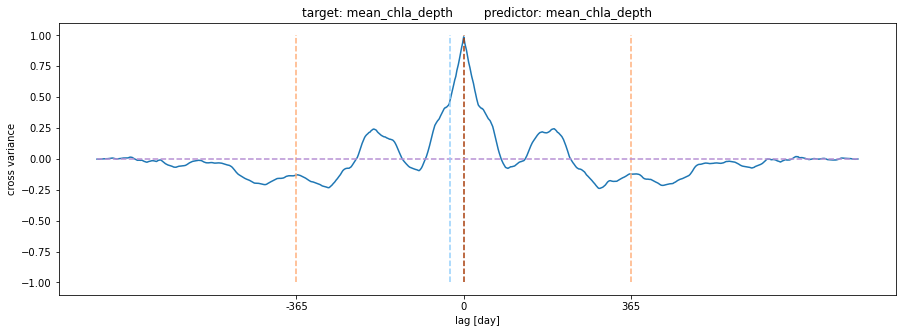

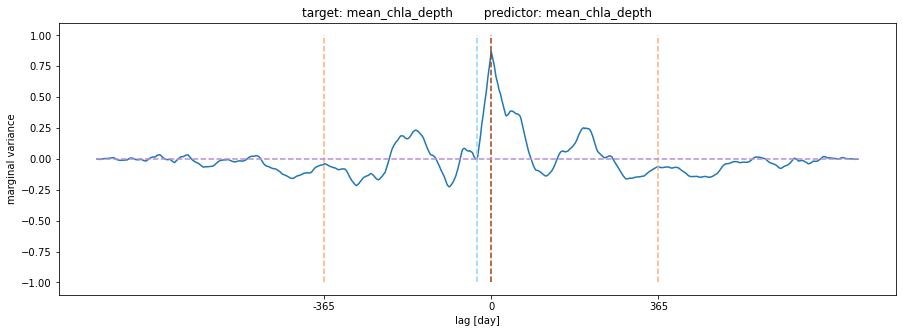

In [381]:
target = 'mean_chla_depth'
predictor = 'mean_chla_depth'
lag1 = 24*30



margin = 100 #doesnt plot the autocorrelation in the margin


dfci = dftv-dftv.mean()
dfci = dfci.fillna(0)



fig,ax = plt.subplots(figsize=(15,5))
target_laged = dfci.loc[dfci.index[lag1:],target].to_numpy()
target_laged = (target_laged-np.mean(target_laged))/np.std(target_laged)
predictor_ts = dfci.loc[dfci.index[lag1:]-pd.Timedelta(lag1,'H'),predictor].to_numpy()
predictor_ts = (predictor_ts-np.mean(predictor_ts))/np.std(predictor_ts)  

crosscor = signal.correlate(target_laged,predictor_ts, mode='full').astype(float)
lags = lag1+signal.correlation_lags(len(target_laged), len(predictor_ts), mode='full')
crosscor /=len(predictor_ts)

ax.plot(lags[margin:-margin],crosscor[margin:-margin])
nyears = 1
for k in range(-nyears,nyears+1):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k*24, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,lags[margin],lags[-margin],linestyles='dashed',color='xkcd:pale purple')
ax.vlines(-lag1,-1,1,linestyles='dashed',color='xkcd:light blue')

ax.set_xticks(np.linspace(-365*nyears*24,365*nyears*24,2*nyears+1))
ax.set_xticklabels(np.linspace(-365*nyears,365*nyears,2*nyears+1,dtype=int))

ax.set_title("target: "+target+"        predictor: "+predictor)
ax.set_xlabel('lag [day]')
ax.set_ylabel('cross variance')
plt.show()




fig,ax = plt.subplots(figsize=(15,5))

marginal_ts = (target_laged-predictor_ts*crosscor[int((len(crosscor)-1)/2)])
marginal_ts -= np.mean(marginal_ts)

mcrosscor = signal.correlate(marginal_ts, predictor_ts, mode='full').astype(float)/len(marginal_ts)/np.std(marginal_ts)
mlags = -lag1-signal.correlation_lags(len(marginal_ts), len(predictor_ts), mode='full')


ax.plot(mlags[margin:-margin],mcrosscor[margin:-margin])
for k in range(-nyears,nyears+1):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k*24, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,mlags[margin],mlags[-margin],linestyles='dashed',color='xkcd:pale purple')
ax.vlines(-lag1,-1,1,linestyles='dashed',color='xkcd:light blue')

ax.set_xticks(np.linspace(-365*nyears*24,365*nyears*24,2*nyears+1))
ax.set_xticklabels(np.linspace(-365*nyears,365*nyears,2*nyears+1,dtype=int))

ax.set_title("target: "+target+"        predictor: "+predictor)
ax.set_xlabel('lag [day]')
ax.set_ylabel('marginal variance')
plt.show()

Note that in theory, the L1 regularizer should be just as able to select the useful variables, but the smaller training time allows to change of time scale: using the seasonality of the blooms can now be done. One can still note that due to the short duration of the time series, using a lag of one year significantly affect the correlation functions, but as in the first notebook, this drawback should decrease as more time passes and the data acquisition continues.

In [147]:
#implementation of the correlation:
class CorrElNet:
    def __init__(self,target_keys:list,n_feat,n_para=1,**elast_kwarg):
        from sklearn.linear_model import ElasticNet
        #for the implementation, a different model is used for each variables:
        self.skmodels = [ElasticNet(**elast_kwarg,fit_intercept=False) for _ in target_keys]
        self.n_feat = n_feat
        self.n_para = n_para
        assert n_feat%n_para == 0, f"n_para must divide n_feat"
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.featureUsed = np.empty((len(target_keys),n_feat,2))
        self.featureUsed[:] = np.nan
    def fit(self,inputs,target,breakpoints):
        self.featureUsed[:] = np.nan
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        self._scalerout = self._scalerout.fit(target.values)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target.values)
        ntar = np.nan_to_num(ntar)
        
        #use the breakpoint to pad the correlation function with 0s
        ninp_pad = np.concatenate([ninp[:breakpoints[0]],
                                   np.zeros((breakpoints[1]-breakpoints[0],ninp.shape[1])),
                                   ninp[breakpoints[0]:]])
        ntar_pad = np.concatenate([ntar[:breakpoints[0]],
                                   np.zeros((breakpoints[1]-breakpoints[0],ntar.shape[1])),
                                   ntar[breakpoints[0]:]])
        
        for idx,target in enumerate(self.target_keys):
            for tries in range(self.n_para):
                #find compute the correlation function
                marginal_target = np.copy(np.expand_dims(ntar_pad[:,idx],-1))
                for feature in range(self.n_feat//self.n_para):
                    cor = signal.correlate(ninp_pad,marginal_target, mode='full')/len(marginal_target)
                    cor_lag = signal.correlation_lags(ninp_pad.shape[0],marginal_target.shape[0], mode='full')
                    cor_f = cor[cor_lag<=0,:]
                    cor_lag_f = cor_lag[cor_lag<=0]
                    used_idx = np.reshape(self.featureUsed[idx,:][self.featureUsed[idx,:,:]==self.featureUsed[idx,:,:]].astype(int),
                                          [-1,2])
                    
                    used_idx[:,0]= len(cor_lag_f)-1-used_idx[:,0]
                    if len(used_idx)>0:
                        cor_f[used_idx]=np.nan
                    max_idx = np.unravel_index(np.nanargmax(np.abs(cor_f),axis=None),cor_f.shape)
                    best_lag = -cor_lag_f[max_idx[0]]
                    self.featureUsed[idx,feature+self.n_feat*tries//self.n_para,:]=np.array([best_lag,max_idx[1]])
                    marginal_target[best_lag:,0] = marginal_target[best_lag:,0] - cor[max_idx]*ninp_pad[:len(marginal_target)-best_lag,max_idx[1]]
                    marginal_target = (np.reshape(marginal_target,[-1,1]) - np.mean(marginal_target))/np.std(marginal_target)
        #stack the input variable so that n_feat points are given for each target:
        x = np.zeros((len(ninp_pad),self.n_feat))
        for idx_tar in range(len(self.target_keys)):
            shift = int(np.max(self.featureUsed[idx_tar,:,0]))
            ninp_shifted = np.concatenate([np.zeros((shift,ninp.shape[1])),ninp_pad])
            for i in range(self.n_feat):
                shift_feat = shift-self.featureUsed[idx_tar,i,0].astype(int)
                x[:,i] = ninp_shifted[shift_feat:len(ninp_shifted)-self.featureUsed[idx_tar,i,0].astype(int),
                                              self.featureUsed[idx_tar,i,1].astype(int)]
            y = ntar_pad[:,idx]
            self.skmodels[idx_tar].fit(x,y)
    def pred(self,inputs,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((0,len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        
        #use the breakpoint to pad the correlation function with 0s
        ninp_pad = np.concatenate([ninp[:breakpoints[0]],
                                   np.zeros((breakpoints[1]-breakpoints[0],ninp.shape[1])),
                                   ninp[breakpoints[0]:]])
        npred = np.empty((len(inputs),len(self.target_keys)))
        npred[:,:] = np.nan
     
        #stack the input variable so that the point founds during training are used to predict y
        x = np.zeros((len(ninp),self.n_feat))
        x_pad = np.zeros((len(ninp_pad),self.n_feat))
        for idx_tar in range(len(self.target_keys)):
            shift = int(np.max(self.featureUsed[idx_tar,:,0]))
            ninp_shifted = np.concatenate([np.zeros((shift,ninp.shape[1])),ninp_pad])
            for i in range(self.n_feat):
                shift_feat = shift-self.featureUsed[idx_tar,i,0].astype(int)
                x_pad[:,i] = ninp_shifted[shift_feat:len(ninp_shifted)-self.featureUsed[idx_tar,i,0].astype(int),
                                              self.featureUsed[idx_tar,i,1].astype(int)]
            #remove the padding
            x = np.concatenate([x_pad[:breakpoints[0],:],x_pad[breakpoints[1]:,:]])
            npred[:,idx_tar] = self.skmodels[idx_tar].predict(x)
        return self._scalerout.inverse_transform(npred)


In [160]:
lag = 10
in_keys = dftv.keys()
out_keys = ['mean_chla_depth']
m = CorrElNet(out_keys,10,1,alpha =0.001,l1_ratio = 0.7)
inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
m.fit(inputs_tv,targets_tv,[0,0])
y = m.pred(inputs_tv,[0,0])

In [161]:
n_fold = 3
inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
model = CorrElNet(out_keys,10,1,alpha =0.001,l1_ratio = 0.7)
res = kf.kfold(model,inputs_tv,targets_tv,n_fold)

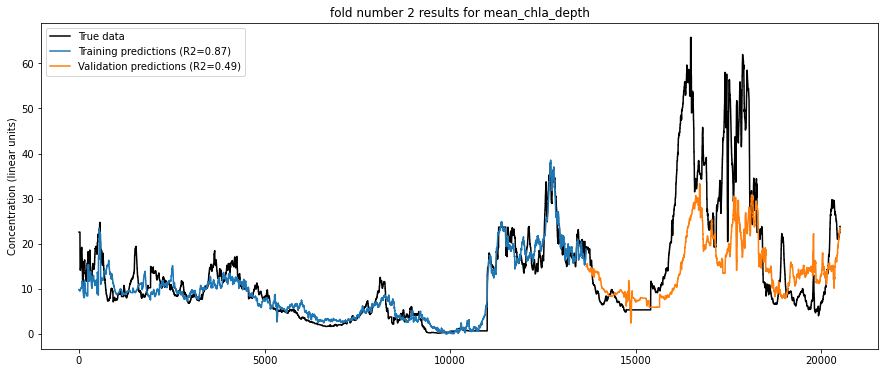

In [162]:
plot_fold(targets_tv,res,2)

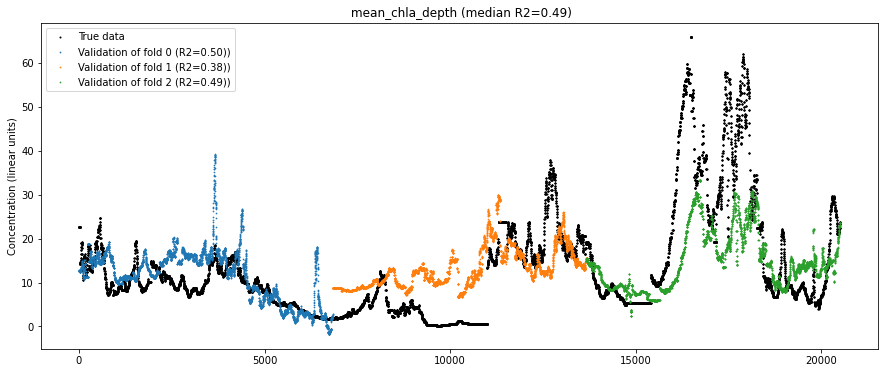

In [163]:
plot_val(targets_tv,res)

In [166]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth']
#chose the models to compare
models = [CorrElNet(out_keys,9,3,alpha =0.01,l1_ratio = 0.7),AR(out_keys,1)]


#models.append(AR(out_keys,1))
models_name = ['CorrElNet(9,3)','AR(1)']
#chose the number of folds
n_fold = 10


res_model = []
for model,model_name in zip(models,models_name):
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*70+f"lag {lag}/{lags[-1]}: "+ model_name,end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kf.kfold(model,inputs_tv,targets_tv,n_fold))
        tar_lag.append(targets_tv)
    res_model.append(res_lag)

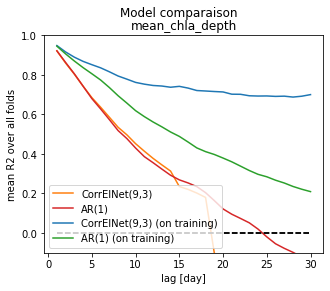

In [167]:
R2_vs_lag(lags,res_model,[tar_lag],title='Model comparaison',model_names = models_name,train=True)

In [16]:
#res_model303 = res_model